# Machine learning for snow cover mapping
*Kehan Yang*, *Aji John*, *Nicoleta Cristea*

### 1. Motivation
Snow is an important component in the Earth's hydrological and energy cycles. Snowpack functions as a natural reservoir that stores water in cold months and slowly releases water into streams, rivers, and lakes, substantially mitigating water stress during the summer. Snow is one of the most reflective land cover types on the Earth’s surface and has positive feedback on climate warming. Temperature increases accelerate snowmelt rate and reduce snow-covered area, SCA, leading to a lower land surface reflectance. More solar radiation will be absorbed by the land surface, which in turn accelerates climate warming.  Snow-covered area (SCA) is a critical variable for studying land processes such as snow-albedo feedback at different spatial scales, impacts on plant phenology and other associated environmental processes, and is also used in land surface models. Therefore, to better understand water availability and the Earth’s energy balance, it is important to estimate the spatial and temporal distribution of the snowpack. 

While mapping SCA using optical satellite remote sensing imagery is very well established, its implications have been restricted by the tradeoff between spatial and temporal resolution over the past decades. Because mountain snowpack has very high spatial heterogeneity and the SCA can change dramatically in the melting season, it is necessary to have SCA observations at both high spatial and temporal resolution. In this context, the Planet small satellites provide new opportunities for SCA mapping. The Planet is a commercial company that launched about 200 satellites in orbit, aiming to provide whole coverage of the Earth daily at about 3-5-meter spatial resolution. All these small satellites can provide observations in visible (i.e., red, green, and blue), and near-infrared bands, where snow surface usually has a very high reflectance compared with other land cover types. 

The first generation of Planet satellites was launched in 2016, which is relatively new to users and its application in SCA mapping is rarely studied. Because Planet imagery does not have a shortwave infrared band, which is necessary to distinguish between snow and clouds, it is inapplicable to use the traditional approach (i.e., Normalized Difference Snow Index) to map SCA from Planet images. It becomes even more challenging that only four bands of information are provided which may not be enough to capture the main spectrum features of land cover types in remote sensing classification. In this context, we propose to use machine learning models to map SCA from Planet imagery. Specifically in this chapter, we will demonstrate how we prepare the model inputs, how we tune model parameters and select the best model, and how we evaluate model performance. The objectives of this chapter are to:
1) demonstrate how we can use machine learning models to map SCA from high-resolution satellite imagery.

2) generate a workflow that can be used repeatedly for future applications.

3) develop tutorial materials for educational purposes. All the scripts and datasets are released through the GitHub Repository.



### 2. Machine learning tools
#### 2.1 What is 'scikit-learn' 
[Scikit-learn](https://scikit-learn.org/stable/) is one of the most powerful and popular python packages designed to facilitate the use of machine learning. It provides various algorithms used for classification, regression, and clustering. In this section, we will be using the random forest algorithm in the scikit-learn package to map SCA.
#### 2.2 What is the random forest algorithm
Random forest is a widely used machine learning algorithm developed by Leo Breiman and Adele Cutler (citation). It is an ensemble of multiple decision trees that are eventually aggregated to get the most likely result. A decision tree is a type of supervised machine learning that bases on a series of questions to categorize or make predictions. Each question forms a tree node that splits the data into different branches. If the answer to the question is ‘yes’, the decision follows the ‘yes’ branch; otherwise, the decision follows the alternate path until it reaches a result. The quality of the results is evaluated by metrics, such as the mean squared error (MSE), Gini Impurity, and information gain. 

While the decision trees algorithm is very easy to use, it can be prone to overfitting issues. Using an ensemble of decision trees can largely reduce the overfitting and prediction variance, providing more accurate results. Bagging, also known as bootstrap aggregation, is the most well-known ensemble learning technique, which trains multiple models independently with the training sample set randomly selected with replacement. The final prediction is determined by the average (for regression) or majority (for classification) of all the models. Random forest is an extension of the bagging approach, which generates a random subset of both samples and features for each model training. While a decision tree is based on all features to make decisions, the random forest algorithm only uses a subset of features, which can reduce the influence of highly correlated features in model prediction. More complex approaches based on image segmentation techniques exist for land cover classification, including snow (citation). For the purpose of this chapter, we chose to illustrate the use of the random forest algorithm for snow classification, as it is a robust and versatile method to address both classification and regression problems.


### 3. Prepare Input data 
The satellite image used in this chapter is provided by the Planet company. Planet company has an [Education and Research Program](https://www.planet.com/markets/education-and-research/) that provides limited, non-commercial access to PlanetScope imagery. The product used in this chapter is the Planet orthorectified product `PS2`, which includes four bands, blue (Band 1, 455-515 nm), green (Band 2, 500-590 nm), red (Band 3, 590-670 nm), and near-infrared (Band4, 780-860 nm). The spatial resolution of the image is 3.7 meters. As a first step, we visualize and inspect the Planet data. The following block of code reads the Planet image over a region in California and plots the results. 


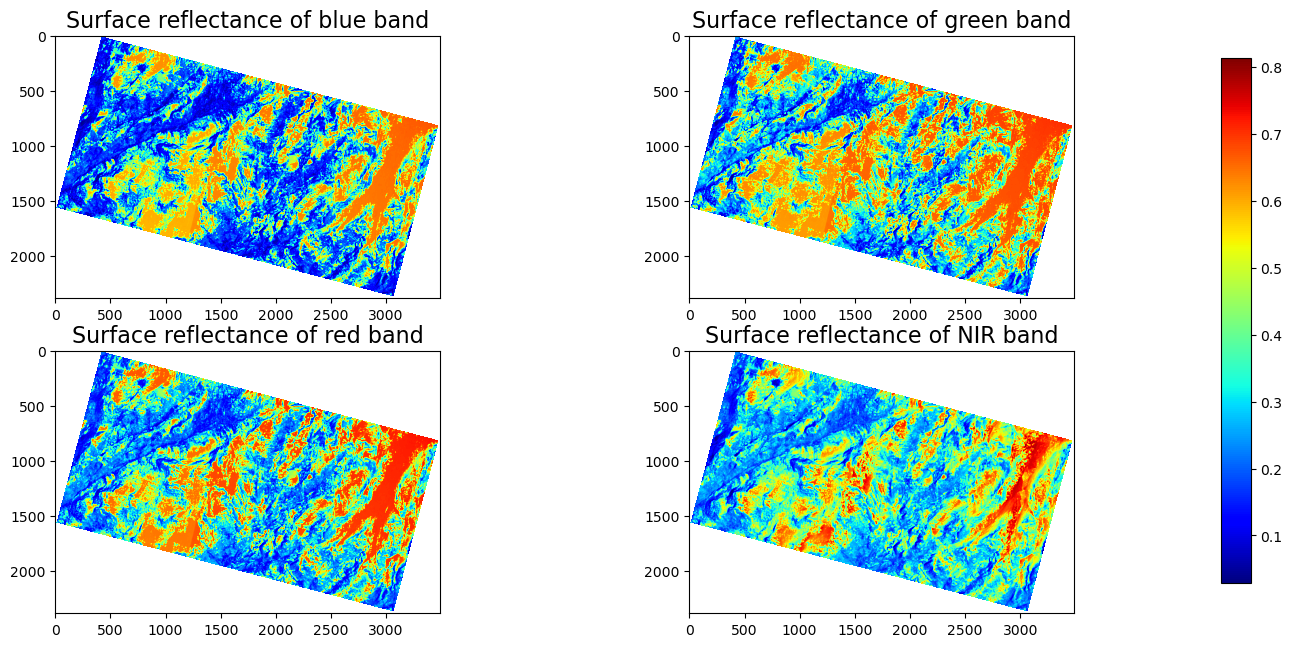

In [1]:
# import functions and packages
from functions_book_chapter_SCA import *

dir_raster = './data/planet/20180528_181110_1025_3B_AnalyticMS_SR_clip.tif'
planet = rasterio.open(dir_raster).read()/10000
planet = np.where(planet[0,:,:] == 0, np.nan, planet) # the default nan data value is 0, replace with np.nan

fig, axs = plt.subplots(2,2,figsize=(15,7.5))
im1 = axs[0,0].imshow(planet[0,:,:],cmap='jet')
axs[0,0].set_title("Surface reflectance of blue band", fontsize=16)

im2 = axs[0,1].imshow(planet[1,:,:], cmap='jet')
axs[0,1].set_title("Surface reflectance of green band", fontsize=16)

im3 = axs[1,0].imshow(planet[2,:,:], cmap='jet')
axs[1,0].set_title("Surface reflectance of red band", fontsize=16)

im4 = axs[1,1].imshow(planet[3,:,:], cmap='jet')
axs[1,1].set_title("Surface reflectance of NIR band", fontsize=16)

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax)

The figure above shows the surface reflectance of the four bands in the PlanetScope image `20180528_181110_1025_3B_AnalyticMS_SR_clip.tif` within a region of the Tuolumne Basin, California. The red and orange colors represent high surface reflectance, while the cyan and dark blue colors represent low surface reflectance. Because snow has a very high reflectance in the visible bands, those red and orange regions are very likely to be covered by snow.

In the next step, we carefully drew a few ROIs (i.e., Region of Interest) on the image and labeled each ROI as ‘1’ or ‘0’. ‘1’ represents ‘snow’, while ‘0’ represents ‘no-snow’. We label the ROIs based on visual inspection. We only considered the binary classification because the mixing pixel issue is not significant for the Planet image at such a high spatial resolution (3.7 meter), even though it is also not negligible, especially at the edge of snowpack and no-snow land surface. For the demonstration purpose, we will only show the binary classification, “snow” and “no-snow” in this chapter.
We extracted the surface reflectance of all bands of each pixel inside the ROIs and generated an input feature table with 100,000 samples (i.e., ‘sample_100K.csv’). Here, one pixel is equivalent to one sample. Each sample has four feature columns (blue, green, red, and nir) and one label column (label). In Section 4, we will discuss the influence of sample size on model performance. 


In [2]:
# read model input features and labels 
data = pd.read_csv('./data/samples/sample_100K.csv', index_col = False)
print("Sample dimentions:".format(), data.shape)
print(data.head())
X = data[['blue','green','red','nir']]
y = data['label']

Sample dimentions: (100000, 5)
     blue   green     red     nir  label
0  0.5948  0.4274  0.6514  0.6841      1
1  0.1088  0.1296  0.1580  0.2639      0
2  0.7735  0.5578  0.8296  0.7552      1
3  0.1581  0.1793  0.2152  0.2700      0
4  0.5916  0.4253  0.6499  0.6401      1


* `blue`: The surface reflectance of the blue band (455-515 nm). Surface reflectance is the fraction of incoming solar radiation that is reflected further from the Earth's surface. It typically ranges from 0 to 1. The original surface reflectance value extracted from the Planet ‘PS2’ product is scaled by 10,000. Here, we have transferred the original values to real surface reflectance as shown in the table.

* `green`: The surface reflectance of the green band (500-590 nm). 

* `red`: The surface reflectance of the red band (590-670 nm). 

* `nir`: The surface reflectance of the near-infrared band (780-860 nm).

* `label`: '0' is no-snow land surface, '1' is snow surface. 


### 4. Model parameter tuning 
Parameter selection is a very critical step in machine learning model fitting. In our experiment, we apply the random forest model to map Planet SCA, and there are several important parameters used in the model training process. To get an optimal set of these parameters as well as the sample size, we conducted a sensitivity test of the following four parameters on the overall model accuracy, including the number of samples, number of features, number of trees, and tree depth. 
Specifically, we will use the ‘RandomForestClassifier’ function from [sklearn.ensemble](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier) to define the random forest model. The main parameters to customize the model include ‘n_estimators’, ‘max_depth’, and ‘max_features’.

* `n_estimators` is the number of trees in the forest. Normally, a larger tree number would result in a better model performance, but it also means a longer model training time. Additionally, the model performance will stop getting significantly better beyond a critical number of trees. 

* `max_features` is the size of feature subsets used in splitting a node. A good empirical value of max_features is ‘None’ for regression problems, which considers all features instead of a random subset, and ‘sqrt’ for classification tasks, which uses a random subset of size sqrt(n_features).

* `max_depth` is the maximum depth of the tree. A deeper tree has more splits and capture more information about the data. Similar to the number of trees, the model performance will stop getting significantly better once tree depth is deep enough.



First, we read the sample data using the code below. To reduce the calculation time, we select 10,000 samples instead of the entire 100,000 sample as the model performance does not show significant improvement when the sample size reaches around 4000 (section 4.1). We use k-fold cross-validation (k = 10) to evaluate model performance with 100 repeat times.

In [3]:
# prepare data 
data = pd.read_csv('./data/samples/sample_10K.csv', index_col = False)
print("Sample dimentions:".format(), data.shape)
data.head()
X = data[['blue','green','red','nir']]
y = data['label']

Sample dimentions: (10000, 5)


#### 4.1. Number of samples
Theoretically, the performance of random forest models can continually improve as the sample size increases. However, training a model with a large sample size would result in a high computational expense, and oftentimes, the model accuracy does not change significantly beyond a critical number of samples. 

We generated a custom function ‘get_model_size()’ to train random forest models with different sample size. We proportionately selected samples by changing ‘max_samples’ parameter. The “max_samples” argument can be set to a float between 0 and 1 to control the percentage of the training dataset to make the bootstrap sample used in each decision tree training. All custom functions are organized in the ‘functions_SCA_mapping.py’ and available to download in the GitHub repository for your interests.

To reduce the calculation time, we only show the percentages ranging from 0.01 to 0.1 with a 0.01 interval, and the percentages ranging from 0.1 to 1.0 with a 0.1 interval in the experiment below. The result shows that the overall model accuracy improves with the increasing sample size when the percentage increases from 0.01 to 0.08 (i.e., 100 to 800 samples), followed by a very slight improvement with the percentage increases from 0.08 to 0.4 (i.e., 800 to 4 k samples). The model performance changes negligibaly after the sample size reaches 4000 (i.e., 0.4 percentage), meaning that the whole dataset can be very well represented by a subset with 4000 observations. Therefore, we will use 4000 as the optimal sample size to train the SCA model.


>Sample size: 100   Mean Score: 0.997142 (Score SD: 0.001643)
>Sample size: 200   Mean Score: 0.997614 (Score SD: 0.001483)
>Sample size: 300   Mean Score: 0.997776 (Score SD: 0.001419)
>Sample size: 400   Mean Score: 0.997920 (Score SD: 0.001375)
>Sample size: 500   Mean Score: 0.998051 (Score SD: 0.001367)
>Sample size: 600   Mean Score: 0.998204 (Score SD: 0.001313)
>Sample size: 700   Mean Score: 0.998309 (Score SD: 0.001273)
>Sample size: 800   Mean Score: 0.998413 (Score SD: 0.001231)
>Sample size: 900   Mean Score: 0.998454 (Score SD: 0.001201)
>Sample size: 1000   Mean Score: 0.998468 (Score SD: 0.001203)
>Sample size: 2000   Mean Score: 0.998523 (Score SD: 0.001167)
>Sample size: 3000   Mean Score: 0.998621 (Score SD: 0.001159)
>Sample size: 4000   Mean Score: 0.998709 (Score SD: 0.001123)
>Sample size: 5000   Mean Score: 0.998732 (Score SD: 0.001131)
>Sample size: 6000   Mean Score: 0.998721 (Score SD: 0.001129)
>Sample size: 7000   Mean Score: 0.998723 (Score SD: 0.001131)
>

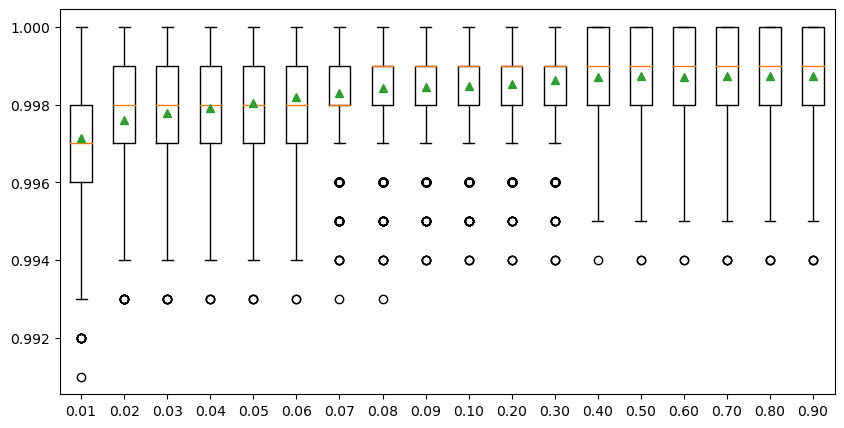

In [4]:
# customize models with different sample sizes
models = get_models_size()
results, names = list(), list()
for name, model in models.items():
    # evaluate models using k-fold cross-validation
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    # print the mean and standard deviation of models 
    print('>%s   Mean Score: %.6f (Score SD: %.6f)' % ('Sample size: ' + str(int(float(name) * 10000)), scores.mean(), scores.std()))
    
# display model performance 
plt.figure(figsize=(10,5))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

#### 4.2 Number of features 
The number of features for each split node is perhaps the most important feature to configure in our random forest model, and it is set via the ‘max_features’ parameter. To explore the influence of feature numbers on model accuracy, we tested model accuracy with the ‘max_features’ ranging from 1 to 4. The result shows that the median accuracy (green triangle) of the experiments with max_features = 4 is slightly higher than the other three max_features values, though no significant difference is observed among all four test sets.
The default of max_features is the square root of the number of input features. This would be sqrt(4) or two features for our test dataset. However, the total feature size we have is already very small and the model shows slightly better performance when max_features = 4. Also, we do not want to lose any information from these four bands. Therefore, we decided to use the max_features = 4 in the SCA model training.


>Features: 1   Mean Score: 0.998754 (Score SD: 0.001105)
>Features: 2   Mean Score: 0.998747 (Score SD: 0.001114)
>Features: 3   Mean Score: 0.998803 (Score SD: 0.001114)
>Features: 4   Mean Score: 0.998834 (Score SD: 0.001113)


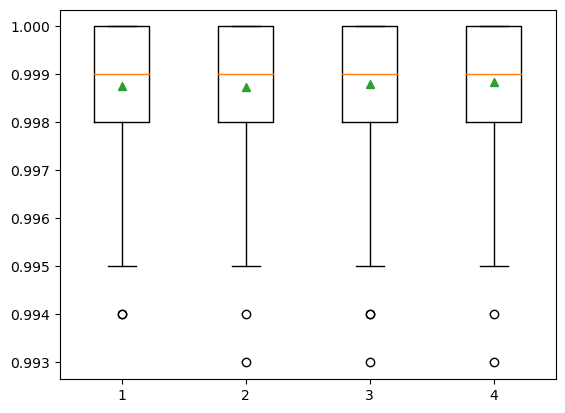

In [5]:
# customize models with different model feature sizes
models = get_models_feature()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate models using k-fold cross-validation
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    # print the mean and standard deviation of models 
    # print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
    print('>%s   Mean Score: %.6f (Score SD: %.6f)' % ('Features: ' + name, scores.mean(), scores.std()))
# display model performance 
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

#### 4.3 Number of trees 
The number of trees is another key parameter to configure in a random forest model. The number of trees can be set via the “n_estimators'' and the default value is 100. The example below explores the effect of the number of trees on model performance. We set the ‘n_estimators’ to the values between 1 to 1,000, with only a few selected tree numbers displayed in the boxplot. Typically, when we increase the number of trees, the model performance increases but it will stabilize when we have enough trees. In this case, the change in model performance is negligible when the number of trees reaches 10, and thus we will use n_estimators = 10 in our SCA model.


>Tree numbers: 1   Mean Score: 0.998293 (Score SD: 0.001369)
>Tree numbers: 2   Mean Score: 0.998456 (Score SD: 0.001235)
>Tree numbers: 3   Mean Score: 0.998620 (Score SD: 0.001188)
>Tree numbers: 4   Mean Score: 0.998646 (Score SD: 0.001142)
>Tree numbers: 5   Mean Score: 0.998706 (Score SD: 0.001134)
>Tree numbers: 10   Mean Score: 0.998710 (Score SD: 0.001113)
>Tree numbers: 20   Mean Score: 0.998731 (Score SD: 0.001123)
>Tree numbers: 50   Mean Score: 0.998747 (Score SD: 0.001113)
>Tree numbers: 100   Mean Score: 0.998756 (Score SD: 0.001107)
>Tree numbers: 200   Mean Score: 0.998755 (Score SD: 0.001118)
>Tree numbers: 800   Mean Score: 0.998774 (Score SD: 0.001109)
>Tree numbers: 1000   Mean Score: 0.998772 (Score SD: 0.001114)


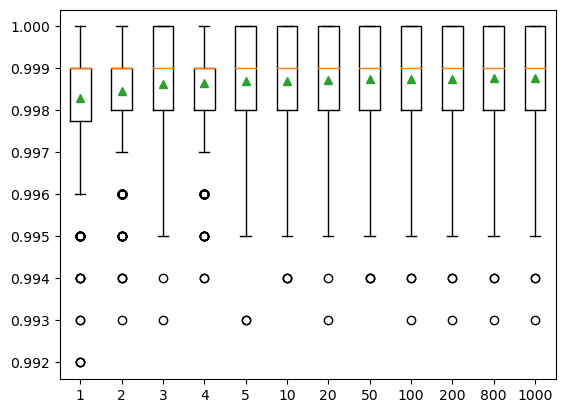

In [6]:
# customize models with different tree numbers
models = get_models_tree()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate models using k-fold cross-validation
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    # print the mean and standard deviation of models 
    # print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
    print('>%s   Mean Score: %.6f (Score SD: %.6f)' % ('Tree numbers: ' + name, scores.mean(), scores.std()))
# display model performance 
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

#### 4.4 Tree depth 
The last parameter is the maximum depth of decision trees and can be set via ‘max_depth’. Ideally, we would like as many trees as possible to improve model performance, so the ‘max_depth’ is set to None by default, meaning no maximum depth. Reducing tree depth would make the ensemble converge a little earlier, but a large tree depth will lead to a longer computing time. We need a tree depth that is enough to split each node for our samples within an acceptable time. The example below explores the effect of maximum tree depth on model performance. The result shows that the model performance does not have a significant difference when the ‘max_depth’ is greater than 8 and stabilized when the tree depth is 10. So, we decided to set ‘max_depth’ to 10 in our SCA model. 


>Tree Depth: 1   Mean Score: 0.998314 (Score SD: 0.001249)
>Tree Depth: 2   Mean Score: 0.998485 (Score SD: 0.001176)
>Tree Depth: 3   Mean Score: 0.998417 (Score SD: 0.001200)
>Tree Depth: 4   Mean Score: 0.998479 (Score SD: 0.001176)
>Tree Depth: 5   Mean Score: 0.998541 (Score SD: 0.001144)
>Tree Depth: 6   Mean Score: 0.998602 (Score SD: 0.001172)
>Tree Depth: 7   Mean Score: 0.998641 (Score SD: 0.001150)
>Tree Depth: 8   Mean Score: 0.998707 (Score SD: 0.001126)
>Tree Depth: 9   Mean Score: 0.998742 (Score SD: 0.001114)
>Tree Depth: 10   Mean Score: 0.998745 (Score SD: 0.001127)
>Tree Depth: 11   Mean Score: 0.998755 (Score SD: 0.001118)
>Tree Depth: 12   Mean Score: 0.998760 (Score SD: 0.001116)
>Tree Depth: 13   Mean Score: 0.998749 (Score SD: 0.001115)
>Tree Depth: 14   Mean Score: 0.998748 (Score SD: 0.001114)
>Tree Depth: 15   Mean Score: 0.998751 (Score SD: 0.001118)
>Tree Depth: 16   Mean Score: 0.998754 (Score SD: 0.001120)
>Tree Depth: 17   Mean Score: 0.998762 (Score SD:

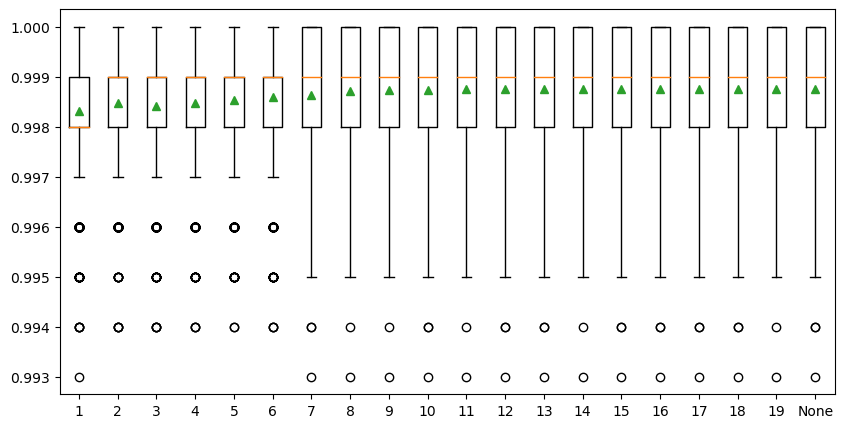

In [7]:
# customize models with different tree depths
models = get_models_depth()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
     # evaluate models using k-fold cross-validation
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    # print the mean and standard deviation of models 
    # print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
    print('>%s   Mean Score: %.6f (Score SD: %.6f)' % ('Tree Depth: ' + name, scores.mean(), scores.std()))
# display model performance 
plt.figure(figsize=(10,5))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

### 5. How to train random forest models
With the tests conducted in the last section, we have the optimal values of the four main parameters that we will use in our SCA model. Our next step is to train the random forest model for SCA mapping.

#### 5.1 Split data into training and testing subsets
In this step, we split observations into a training subset and a testing subset. Usually, we want to use 70-80% of the data for training, and the remaining 70-80% of the data for testing. However, we find that the model accuracy is reaching a stable stage when the sample size reaches 4000 in the model parameter sensitivity analysis (Section 4.1). Therefore, we only use 4000 samples, with the remaining 96,000 samples used as an evaluation testing subset to improve model training efficiency.

We use the ‘train_test_split’ function from the ‘sklearn.model_selection’ module to randomly split the sample dataset into training and test subsets. 

The parameter ‘test_size’ can be float or integer. If it is a float, the value should be between 0.0 and 1.0, representing the proportion of the dataset to include in the test split. If it is an integer, it represents the absolute number of the train samples. 

The ‘random_state’ parameter is very useful for making the model sampling reproducible. Here, we assign ‘1’ to ‘random_state’. It does not matter what the actual ‘random_state’ number is. It could be any number, but the important thing is that every time we use ‘1’, just the same as the first time we make the split, we will get the same splits, which is very useful for the demonstration.


In [8]:
# read model input features and labels 
data = pd.read_csv('./data/samples/sample_100K.csv', index_col = False)
print("Sample dimentions:".format(), data.shape)
print(data.head())
X = data[['blue','green','red','nir']]
y = data['label']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.96,random_state=1)

Sample dimentions: (100000, 5)
     blue   green     red     nir  label
0  0.5948  0.4274  0.6514  0.6841      1
1  0.1088  0.1296  0.1580  0.2639      0
2  0.7735  0.5578  0.8296  0.7552      1
3  0.1581  0.1793  0.2152  0.2700      0
4  0.5916  0.4253  0.6499  0.6401      1


#### 5.2 Define the random forest model
Now, as we have the training subset and the optimal parameters, we can run the ‘RandomForestClassifier()’ to train our model using the code below:


In [9]:
# define the model
model = RandomForestClassifier(n_estimators=10, max_depth=10, max_features=4)

To evaluate the model performance, we conduct K-fold cross-validation using ‘RepeatedStratifiedKFold’ and ‘cross_val_score’ from ‘sklearn.model_selection’. Here, the training subset is randomly split into 10 folds evenly, and each fold is literally used to test the model which is trained by the remaining 9 folds of data. This process is repeated until each fold of the 10 folds has been used as the testing set. The average evaluation metric, here the ‘accuracy’, is used to represent the model performance. This whole process is repeated 1000 times to get the final model performance reported as below:


In [10]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1000)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report model performance
print('Mean Score: %.6f (SD: %.6f)' % (n_scores.mean(),n_scores.std()))

Mean Score: 0.998063 (SD: 0.002131)


The overall model training accuracy is 0.998 with 0.002 standard deviation over the 1000 repeated cross-validations, indicating that only 0.2% of samples or pixels on average are incorrectly classified. If we look at the distribution of the accuracy values as shown below, most accuracy values are clustered near 1.00 and all values are higher than 0.98, indicating the model training is very precise and robust. 


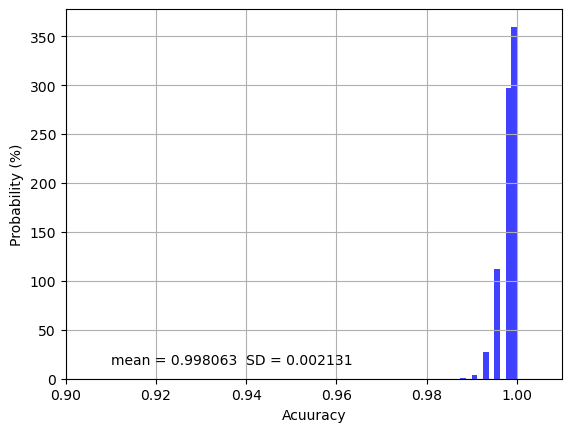

In [11]:
# the histogram of the scores
n, bins, patches = plt.hist(n_scores, density=True, facecolor='blue', alpha=0.75)
plt.text(0.91, 15, r'mean = ' + str(n_scores.mean().round(6)) + '  '+ 'SD = ' + str(n_scores.std().round(6)))
plt.xlim(0.9, 1.01)
plt.xlabel('Acuuracy')
plt.ylabel('Probability (%)')
plt.grid(True)
plt.show()

#### 5.3 Feature importance
It is important to explore each feature's importance, especially when the feature size is very large, and many features are redundant. In our case, it is not necessary to reduce feature size as we only have four features, but we want to know which band provides the most significant information in the SCA mapping. 

We use [‘permutation_importance’](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) form ‘sklearn.inspection’ to estimate feature importance. The function of the permutation feature importance is described as [below](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance):

`The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.`

As the random forest algorithm trains the model with randomly selected sample subsets and feature subsets, each model run would have a different estimate of feature importance. Thus, to get a robust estimate of feature importance, we repeated the process 1000 times as shown below. 
The result shows that the blue band provides the most important information for SCA mapping, while other three bands all show much less important.


Permutation importance - average: Index(['blue', 'green', 'red', 'nir'], dtype='object')
[0.51731, 0.000415, 0.000352, 0.000973]


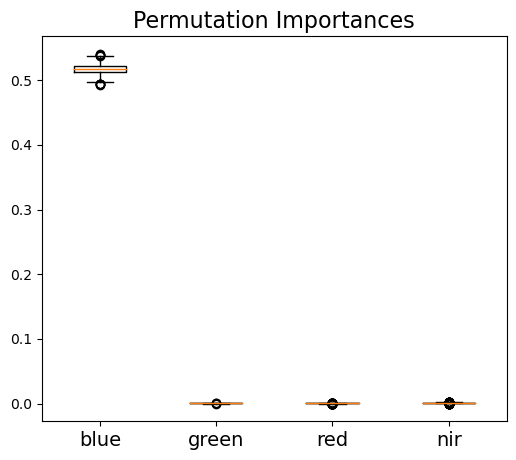

In [12]:
model.fit(X_train,y_train)
result = permutation_importance(model, X_train, y_train, n_repeats=1000, random_state=42, n_jobs=2)
print('Permutation importance - average:'.format(), X_train.columns)
print([round(i, 6) for i in result.importances_mean])

# displace feature importance
fig, ax = plt.subplots(figsize=(6,5))
ax.boxplot(result.importances.T)
ax.set_title("Permutation Importances", fontsize = 16)
ax.set_xticklabels(labels=X_train.columns, fontsize=14)
plt.show()

#### 5.4 Save the model
We now have our model trained and evaluated. We can save the model using the ‘dump()’ function from the ‘joblib’ package as shown below, so that next time when we want to apply this model, we do not have to run through the process mentioned ahead again. In the next section, we will discuss how we load this model and apply it to a satellite image.


In [13]:
# save model 
dir_model = "./models/random_forest_SCA_binary.joblib"
joblib.dump(model, dir_model)

['./models/random_forest_SCA_binary.joblib']

### 6. Evaluation of model performance
In the previous sections, we trained a model that can accurately predict SCA within the training samples and the overall model accuracy is 0.998 estimated through the k-fold cross-validation approach. However, we do not know how the model performs outside the training subset. To provide a more comprehensive model evaluation, and especially to test the model transferability, we provide the following two levels of assessment:
1) As the model training only needs 4000 samples, we have 96,000 samples remaining for evaluation which are actually geographically located in the same region as the training samples. We can therefore assume that this testing subset has similar spectrum and physiographic features compared with the training subset, and thus the prediction is expected to be accurate.  

2) To ensure that we have a robust model,  we would also want to know how the model performs over the entire satellite image, and across various land cover types. One challenge we usually face when working with remotely-sensed data is that there is limited high-resolution ground-truth datasets we can use as validation datasets. We have the same issue. Previous study has applied high-resolution lidar-derived SCA data as ‘ground truth’ to evaluate snow cover (Cannistra et al., 2021) given the relatively high accuracy of lidar snow depth measurement. Here, we chose to use the same dataset for SCA evaluation. Specifically, we will use the lidar-derived high-resolution snow depth data at 3-m spatial resolution provided by the Airborne Snow Observatory (ASO, Painter et al., 2016) to map SCA. The lidar snow depth dataset does not provide direct SCA information, so we will use a threshold on the snow depth data to calculate SCA. 

The ASO conducts airborne surveys for some selected watersheds in California and Colorado. The aircraft carries a lidar sensor to map snow depth based on the elevation difference between snow-on and snow-off surfaces. The uncertainty of the final snow depth product at the 3-meter resolution is unbiased with a root mean squared error (RMSE) of 8 cm ([Painter et al., 2016](https://www.sciencedirect.com/science/article/pii/S0034425716302577)). 

A previous study by Cannistra et al., 2021 used 10 cm as a threshold to convert the ASO 3-meter snow depth data into a binary SCA map. If the snow depth is deeper than 10 cm, the pixel is classified as a snow pixel; otherwise, the pixel is a no-snow pixel. While using different thresholds will result in different SCA maps, we find that using a threshold between 8-10 cm gives the best agreement between planet SCA and ASO snow depth derived SCA (John et al., 2022, in review). So, we follow Cannistra et al., 2021 and apply 10 cm to derive SCA from ASO snow depth.

The left figure below shows the spatial distribution of snow depth for the study domain, and the right figure shows the distribution of binary snow-covered areas. The white regions represent ASO SCA.


Text(0.5, 1.0, 'ASO snow cover (TH = 10 cm)')

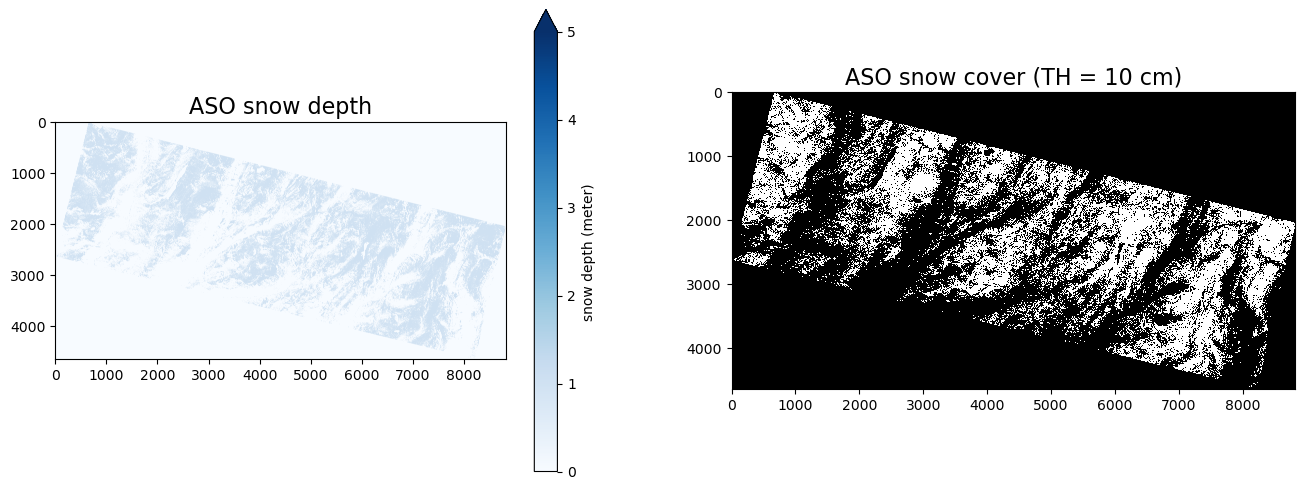

In [16]:
dir_aso = './data/ASO/ASO_3M_SD_USCATE_20180528_binary_clip.tif'
raso = rasterio.open(dir_aso,'r').read()
raso = np.where(raso[0,:,:] < 0, np.nan, raso)

th = 0.1 # using 10 cm threshold
raso_binary = np.where(raso >= 0.1, 1, 0) # if the SD is higher than 10 cm, then snow; otherwise, no-snow

fig, axs = plt.subplots(1,2,figsize=(16,6))
im1 = axs[0].imshow(raso[0,:,:],cmap = 'Blues',vmin = 0, vmax = 5)
axs[0].set_title('ASO snow depth', fontsize=16)
fig.colorbar(im1, ax = axs[0], label = 'snow depth (meter)', extend = 'max')

im2 = axs[1].imshow(raso_binary[0,:,:], cmap = 'gray', interpolation = 'none')
axs[1].set_title('ASO snow cover (TH = 10 cm)', fontsize=16)

The following five evaluation metrics are used to represent model prediction accuracy:

$$ Precision = TP÷( TP + FP) $$
$$ Recall = TP ÷(TP + FN) $$

$$ F1 = 2 * Precision * Recall ÷(Precision + Recall) $$

$$ Balanced\;accuracy = TP/(TP+FN)+ TN/(TN+FP)÷ 2 $$ 

$$ Accuracy = (TP + TN)÷(TP + TN+ FP + FN) $$


Where TP, TN, FP, FN are true positive, true negative, false positive, and false negative, respectively.

#### 6.1 Testing subset model performance
We run the ‘model.predict()’ to get the snow cover prediction, where the ‘model’ is the SCA mapping model we trained in previous sections. We can use the code below to load the saved model from the directory:

In [17]:
dir_model = "./models/random_forest_SCA_binary.joblib"
# load model
model = joblib.load(dir_model)


Then, we calculate the five evaluation metrics using ‘calculate_metrics()’ which is a custom function we generated to evaluate model performance. 

In [18]:
df = pd.DataFrame()
df['obs'] = y_test
df['predict'] = model.predict(X_test)

# Cross-tabulate predictions
print(pd.crosstab(df['obs'], df['predict'], margins=True))
print(calculate_metrics(df))


predict      0      1    All
obs                         
0        54538     25  54563
1          136  41301  41437
All      54674  41326  96000
   precision    recall        f1  balanced_accuracy  accuracy
0   0.999395  0.996718  0.998055            0.99813  0.998323


From the results printed out above, the false negative is 11 within 54678 no-snow pixels, and the false positive is 22 within 41322 snow pixels. All five evaluation metrics are very close to 1, indicating the model performs very well in the remaining 96,000 testing samples, which is not very surprising as the pixels within the testing subset are located close to the training samples and also have similar spectrum features.
#### 6.2 Image wide model performance 
Now, let’s look at how the model performs across the entire image using the following steps. Firstly, we collect the four bands’ surface reflectance over the entire image, and then we apply a custom python function ‘run_sca_prediction()’ to predict SCA. Finally, we save the SCA image to ‘dir_our’ directory.


In [19]:
dir_raster = './data/planet/20180528_181110_1025_3B_AnalyticMS_SR_clip.tif'
dir_out = './data/SCA/'
nodata_flag = 9
run_sca_prediction(dir_raster, dir_out, nodata_flag, model)

Start to predict: 20180528_181110_1025_3B_AnalyticMS_SR_clip.tif
Image dimension: (4, 2380, 3488)
Save SCA map to:  ./data/SCA/20180528_181110_1025_3B_AnalyticMS_SR_clip_SCA.tif


We display the original Planet false-color image (left) and the predicted SCA map (right) in the figure below. Based on our visual examination, the model predicts SCA precisely and captures the spatial distribution of snow very well. Next, we will compare this Planet SCA with the validation data set – ASO SCA.


<Axes: title={'center': 'Planet Snow Cover'}>

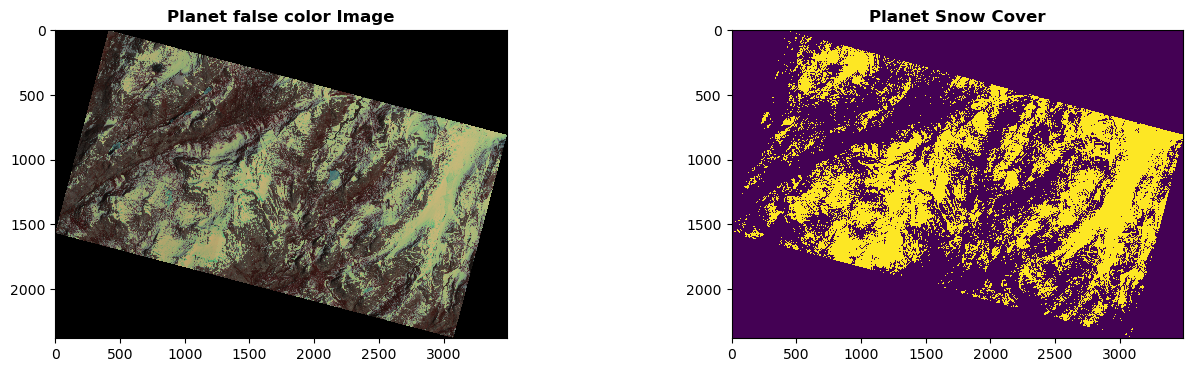

In [20]:
dir_planet = './data/planet/20180528_181110_1025_3B_AnalyticMS_SR_clip.tif'
r_na_flag = rasterio.open(dir_planet, 'r').read()
r_planet = rasterio.open(dir_planet, 'r').read([4,3,2])/10000

dir_sca = './data/SCA/20180528_181110_1025_3B_AnalyticMS_SR_clip_SCA.tif'
r_sca = rasterio.open(dir_sca, 'r')

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,4))
show(r_planet, ax= ax1, cmap='jet', interpolation = 'none',title = 'Planet false color Image')
show(r_sca.read().squeeze(), ax= ax2, interpolation = 'none',title = 'Planet Snow Cover')


To compare the ASO SCA and Planet SCA to the same extent, we firstly read data within the same extent as shown by the yellow outline in the figure below. Because the ASO snow depth product should exclude water bodies and glaciers, we apply the waterbody dataset (data downloaded from [NHDPlus](https://www.epa.gov/waterdata/nhdplus-national-hydrography-dataset-plus#:~:text=National%20Hydrography%20Dataset%20Plus%20(NHDPlus,with%20the%20U.S.%20Geological%20Survey))) and glacier dataset (data downloaded from [Randolph Glacier Inventory 6.0](https://www.glims.org/RGI/rgi60_dl.html)) to mask out those areas.


In [28]:
dir_planet_ext = './data/GIS/extent/CATE_20180528_181110_img_ext.shp'
with fiona.open(dir_planet_ext, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    
dir_aso = './data/ASO/ASO_3M_SD_USCATE_20180528_binary_clip.tif'
with rasterio.open(dir_aso,'r') as src:
    r_aso = rasterio.mask.mask(src, shapes, crop=True, filled = False)
    
dir_pred = './data/SCA/20180528_181110_1025_3B_AnalyticMS_SR_clip_SCA.tif'
with rasterio.open(dir_pred,'r') as src:
    r_predict = rasterio.mask.mask(src, shapes, crop=True, filled = False)

dir_watermask = './data/mask/waterbody_TB_UTM11_clip.tif'
with rasterio.open(dir_watermask,'r') as src:
    r_watermask = rasterio.mask.mask(src, shapes, crop=True, filled = False)
    
dir_glaciermask = './data/mask/02_rgi60_WesternCanadaUS_hypso_TB_clip.tif'
with rasterio.open(dir_glaciermask,'r') as src:
    r_glaciermask = rasterio.mask.mask(src, shapes, crop=True, filled = False)
    


In [29]:
df = pd.DataFrame()
df['predict'] = r_predict[0].ravel()
df['obs'] = r_aso[0].ravel()
df['watermask'] = r_watermask[0].ravel()
df['glaciermask'] = r_watermask[0].ravel()

# remove NA data region, water bodies, and glaciers 
df_mask = df[(df.predict >= 0) & (df.watermask != 0) & (df.glaciermask != 0)]
# print(df)

print("overall model performance:")
print(calculate_metrics(df_mask))

ValueError: Length of values (40926162) does not match length of index (8301440)

The result shows that, overall, 89% of the pixels are classified accurately with the f1 value of 0.87. The model has fewer false-positive predictions than false negative predictions as the precision value (0.89) is slightly higher than the recall value (0.85), indicating a small overall underestimation in SCA modeling. 
#### 6.3 Model performance in open versus forested areas
To explore the potential reasons that explain the mismatch between ASO SCA and Planet SCA, we divide the entire domain into two categories: open areas and forested areas. We use a 3-meter canopy height model dataset provided by ASO. Inc to classify the domain into open and forested areas. If the pixel has a tree height value higher than 1 meter, then this pixel is classified as forest; otherwise, the pixel is classified as open. 

In [ ]:
file_landcover = './data/ASO/ASO_3M_CHM_USCATB_20140827_binary_clip.tif' # 1 - forest, 0 open area
with rasterio.open(file_landcover,'r') as src:
    r_landcover = rasterio.mask.mask(src, shapes, crop=True, filled = False)
    
df['landcover'] = r_landcover[0].ravel()

df_mask = df[(df.predict >= 0) & (df.watermask != 0) & (df.glaciermask != 0)]
df_open = df_mask[df_mask.landcover == 0]
print("Model performance in open areas:")
print(calculate_metrics(df_open))

df_forest = df_mask[df_mask.landcover == 1]
print("Model performance in forested areas:")
print(calculate_metrics(df_forest))

Model performance in open areas:
   precision    recall        f1  balanced_accuracy  accuracy
0   0.891434  0.897947  0.894678           0.899603  0.899687
Model performance in forested areas:
   precision    recall        f1  balanced_accuracy  accuracy
0   0.767677  0.189074  0.303419           0.588665   0.85215


The results show a difference in model accuracy between open and forested areas. For the open areas, the overall model accuracy is 90%, with very similar precision (0.89) and recall (0.90) values, indicating similar false positive and false negative predictions. However, the overall model accuracy for the forested area is only 85%, with relatively high precision (0.77) and an extremely low recall (0.19), indicating much higher false-negative predictions than false positive. The main reason for the high false-negative in forest areas is that Planet uses optical sensors which cannot penetrate canopy cover to get underneath snow cover information while ASO uses a lidar sensor that can penetrate the canopy.



To get a close look at the difference between ASO SCA and Planet SCA, we select two example sites: A and B. Site A is in open terrain with half of the area in a shaded valley and Site B is in a dense forest. 

The model accurately predicts Planet SCA for the open areas in Site A. Even for the shaded terrain where snow and all other land surfaces have low reflectance, the model precisely captured the snow cover with only a small underestimation over the northwest corner. ASO estimates larger SCA in the shaded areas than Planet, but it slightly underestimates SCA in open areas over the southeast corner. 

For Site B, ASO and Planet show significant differences over dense forests. Planet well captures SCA over forest gaps although it shows slight underestimation along forest edges where the mixed pixel issue is not negligible, which is in line with our findings discussed in previous subsections.
![alt text](./data/fig/SCA_result_display.jpeg "Title")

### 7. Conclusion
In this chapter, we develop a random forest model to map snow-covered areas (SCA) from the high-resolution Planet imagery. We demonstrate the influence of four main parameters on model performance, including the number of samples, the number of features, the number of trees, and the tree depth. The optimal parameters determined by these tests are used in the SCA model generation.

The final model shows very precise performance in predicting binary SCA with overall model accuracy of 1.00 and 0.94 at 3-meter spatial resolution when evaluated by the testing subset and the SCA derived from Airborne Snow Observatory (ASO) snow depth dataset, respectively. The model predicted Planet SCA exhibits much higher accuracy for open areas than forested  areas when evaluated by the ASO derived SCA, with an overall accuracy of 0.95 and 0.85, respectively. While the uncertainties in both SCA datasets are not negligible, the main mismatch between Planet SCA and the ASO SCA is caused by the difference in observation sensors. ASO SCA relies on a lidar sensor that can penetrate the canopy, while Planet uses optical sensors that only receive surface reflectance above the canopy. 

In summary, the SCA mapping model we demonstrated in this chapter is very feasible to set up and use. As we only used four bands of information in the model training, this method can be applied to most existing satellite observations like Landsat series imagery, Sentinel-2, and MODIS. The workflow generated in this chapter has critical implications for hydrological process monitoring and prediction, particularly in a world with more dramatic changes in snow cover.

